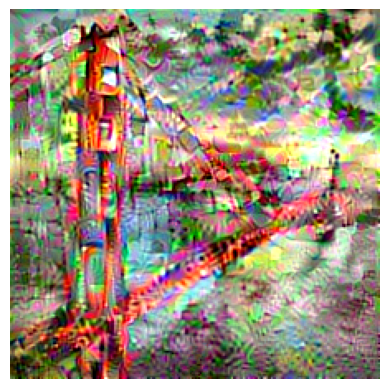

In [27]:
# Import necessary libraries
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Load VGG19 model pre-trained on ImageNet data
vgg19 = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

# Choose the layers for content and style representations
content_layers = ['block5_conv2']
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

# Function to build the model with the selected layers
def build_model():
    vgg19.trainable = False
    content_outputs = [vgg19.get_layer(layer).output for layer in content_layers]
    style_outputs = [vgg19.get_layer(layer).output for layer in style_layers]
    model_outputs = content_outputs + style_outputs
    return tf.keras.models.Model(vgg19.input, model_outputs)

# Function to preprocess the image
def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return tf.keras.applications.vgg19.preprocess_input(img_array)

# Function to deprocess the image
def deprocess_image(processed_img):
    x = processed_img.copy()
    if len(x.shape) == 4:
        x = np.squeeze(x, 0)
    assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
    if len(x.shape) != 3:
        raise ValueError("Invalid input to deprocess image")
    # Perform the inverse of the preprocessing step
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]

    x = np.clip(x, 0, 255).astype('uint8')
    return x

# Function to compute content loss
def content_loss(base_content, target):
    return tf.reduce_mean(tf.square(base_content - target))

# Function to compute style loss
def gram_matrix(input_tensor):
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram / tf.cast(n, tf.float32)

def style_loss(style, combination):
    s = gram_matrix(style)
    c = gram_matrix(combination)
    channels = int(style.shape[-1])
    size = int(style.shape[1]) * int(style.shape[2])
    return tf.reduce_sum(tf.square(s - c)) / (4.0 * (channels ** 2) * (size ** 2))

# Function to compute total variation loss
def total_variation_loss(img):
    x_deltas, y_deltas = img[:, :-1, :-1, :] - img[:, :-1, 1:, :], img[:, :-1, :-1, :] - img[:, 1:, :-1, :]
    return tf.reduce_mean(tf.square(x_deltas) + tf.square(y_deltas))

# Combine all the loss components
def compute_loss(model, base_image, style_reference_image, content_weight, style_weight, total_variation_weight):
    model_outputs = model(base_image)
    content_outputs = model_outputs[:num_content_layers]
    style_outputs = model_outputs[num_content_layers:]

    style_reference_outputs = model(style_reference_image)

    content_loss_val = 0
    style_loss_val = 0
    for target_content, comb_content in zip(content_outputs, style_reference_outputs[:num_content_layers]):
        content_loss_val += content_loss(target_content, comb_content)

    for target_style, comb_style in zip(style_outputs, style_reference_outputs[num_content_layers:]):
        style_loss_val += style_loss(target_style, comb_style)

    content_loss_val *= content_weight / num_content_layers
    style_loss_val *= style_weight / num_style_layers

    total_variation_loss_val = total_variation_weight * total_variation_loss(base_image)

    loss = content_loss_val + style_loss_val + total_variation_loss_val
    return loss, content_loss_val, style_loss_val, total_variation_loss_val

# Function to compute gradients
def compute_grads(cfg):
    with tf.GradientTape() as tape:
        loss = compute_loss(**cfg)[0]
    return tape.gradient(loss, cfg['base_image']), loss

# Function to perform neural style transfer
def style_transfer(content_image_path, style_image_path, num_iterations=1000, content_weight=1e3, style_weight=1e-2, total_variation_weight=30):
    content_image = preprocess_image(content_image_path)
    style_image = preprocess_image(style_image_path)

    model = build_model()

    for layer in model.layers:
        layer.trainable = False

    base_image = tf.Variable(content_image, dtype=tf.float32)

    opt = tf.optimizers.Adam(learning_rate=5, beta_1=0.99, epsilon=1e-1)

    best_loss, best_img = float('inf'), None

    # Create a configuration dictionary
    cfg = {
        'model': model,
        'base_image': base_image,
        'style_reference_image': style_image,
        'content_weight': content_weight,
        'style_weight': style_weight,
        'total_variation_weight': total_variation_weight
    }

    # Main optimization loop
    for i in range(num_iterations):
        grads, loss = compute_grads(cfg)
        opt.apply_gradients([(grads, base_image)])
        if loss < best_loss:
            best_loss = loss
            best_img = base_image.numpy()

    # Deprocess the final image
    final_img = deprocess_image(best_img)

    # Display the final stylized image
    plt.imshow(final_img)
    plt.axis('off')
    plt.show()

# Example usage
content_image_path = '/content/candy.jpg'
style_image_path = '/content/golden_gate.jpg'
style_transfer(content_image_path, style_image_path)
